# **Final Project**

##**Problem stament :**     

The widespread dissemination of fake news and propaganda presents serious societal risks, including the erosion of public trust, political polarization, manipulation of elections, and the spread of harmful misinformation during crises such as pandemics or conflicts. From an NLP perspective, detecting fake news is fraught with challenges. Linguistically, fake news often mimics the tone and structure of legitimate journalism, making it difficult to distinguish using surface-level features. The absence of reliable and up-to-date labeled datasets, especially across multiple languages and regions, hampers the effectiveness of supervised learning models. Additionally, the dynamic and adversarial nature of misinformation means that malicious actors constantly evolve their language and strategies to bypass detection systems. Cultural context, sarcasm, satire, and implicit bias further complicate automated analysis. Moreover, NLP models risk amplifying biases present in training data, leading to unfair classifications and potential censorship of legitimate content. These challenges underscore the need for cautious, context-aware approaches, as the failure to address them can inadvertently contribute to misinformation, rather than mitigate it.



Use datasets in link : https://drive.google.com/drive/folders/1mrX3vPKhEzxG96OCPpCeh9F8m_QKCM4z?usp=sharing
to complete requirement.

## **About dataset:**

* **True Articles**:

  * **File**: `MisinfoSuperset_TRUE.csv`
  * **Sources**:

    * Reputable media outlets like **Reuters**, **The New York Times**, **The Washington Post**, etc.

* **Fake/Misinformation/Propaganda Articles**:

  * **File**: `MisinfoSuperset_FAKE.csv`
  * **Sources**:

    * **American right-wing extremist websites** (e.g., Redflag Newsdesk, Breitbart, Truth Broadcast Network)
    * **Public dataset** from:

      * Ahmed, H., Traore, I., & Saad, S. (2017): "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques" *(Springer LNCS 10618)*



## **Requirement**

A team consisting of three members must complete a project that involves applying the methods learned from the beginning of the course up to the present. The team is expected to follow and document the entire machine learning workflow, which includes the following steps:

1. **Data Preprocessing**: Clean and prepare the dataset,etc.

2. **Exploratory Data Analysis (EDA)**: Explore and visualize the data.

3. **Model Building**: Select and build one or more machine learning models suitable for the problem at hand.

4. **Hyperparameter set up**: Set and adjust the model's hyperparameters using appropriate methods to improve performance.

5. **Model Training**: Train the model(s) on the training dataset.

6. **Performance Evaluation**: Evaluate the trained model(s) using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix, etc.) and validate their performance on unseen data.

7. **Conclusion**: Summarize the results, discuss the model's strengths and weaknesses, and suggest possible improvements or future work.





# **1. Tiền xử lý dữ liệu: đọc, gộp, làm sạch**

In [ ]:
import pandas as pd
df=None
try:
    # Đọc dữ liệu tin đúng và tin giả từ 2 file csv
    true_articles_df = pd.read_csv('DataSet_Misinfo_TRUE.csv')
    fake_articles_df = pd.read_csv('DataSet_Misinfo_FAKE.csv')

    # Gán nhãn cho mỗi loại tin (1 là thật, 0 là giả)
    true_articles_df['label'] = 1 # 1 for true
    fake_articles_df['label'] = 0 # 0 for fake

    # Gộp 2 DataFrame lại thành 1
    df = pd.concat([true_articles_df, fake_articles_df], ignore_index=True)

    # Xóa cột không cần thiết (nếu có)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
        
    print("Data loaded successfully.")
    print("First 5 rows of the combined dataframe:")
    display(df.head())
    print("\nInfo of the combined dataframe:")
    display(df.info())
    print("\nShape of the combined dataframe:")
    print(df.shape)

except FileNotFoundError:
    print("Không tìm tháy files")
except Exception as e:
    print(f"An error occurred: {e}")


Data loaded successfully.
First 5 rows of the combined dataframe:


,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1



Info of the combined dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78617 entries, 0 to 78616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


None


Shape of the combined dataframe:
(78617, 2)


In [ ]:
# Kiểm tra và loại bỏ các dòng trùng lặp
print("\nChecking for duplicate rows:")
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)
print("\nShape after dropping duplicates:")
print(df.shape)


Checking for duplicate rows:
10012

Shape after dropping duplicates:
(68605, 2)


In [ ]:
# Xóa các dòng bị thiếu dữ liệu ở cột 'text'
df.dropna(subset=['text'], inplace=True)

print("\nChecking for missing values after dropping rows with missing text:")
display(df.isnull().sum())
print("\nShape after dropping rows with missing text:")
print(df.shape)


Checking for missing values after dropping rows with missing text:


text     0
label    0
dtype: int64


Shape after dropping rows with missing text:
(68604, 2)


In [ ]:
# Sao chép dữ liệu để dùng cho các mô hình học máy sau này 
df_deeplearning = df.copy()
df_rnn = df.copy()

# **2. Khám phá dữ liệu (EDA)**

In [ ]:
print(f"Shape of combined dataset: {df.shape}")
print(f"Number of true articles: {len(true_articles_df)}")
print(f"Number of false articles: {len(fake_articles_df)}")
print(f"Label distribution:\n{df['label'].value_counts()}")

Shape of combined dataset: (68604, 2)
Number of true articles: 34975
Number of false articles: 43642
Label distribution:
label
1    34526
0    34078
Name: count, dtype: int64


# **3. Trích xuất đặc trưng số từ văn bản** 

In [ ]:
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Hàm trích xuất đặc trưng: số từ, ký tự, độ dài trung bình từ, số từ in hoa, số dấu câu, số stopwords
def extract_features(text):
    # Ensure text is a string before splitting
    if not isinstance(text, str):
        text = "" 

    words = text.split()
    num_words = len(words)
    num_chars = len(text)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    num_upper = sum(1 for w in words if w.isupper())
    num_punct = sum(1 for c in text if c in string.punctuation)
    num_stopwords = sum(1 for w in words if w.lower() in stop_words)

    return pd.Series([
        num_words, num_chars, avg_word_len, num_upper, num_punct, num_stopwords
    ])

# Áp dụng hàm lên cột text và thêm vào DataFrame
df[['num_words', 'num_chars', 'avg_word_len', 'num_upper', 'num_punct', 'num_stopwords']] = df['text'].apply(extract_features)

# Xem thử dữ liệu sau khi thêm đặc trưng
print("\nDataFrame with extracted features:")
display(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



DataFrame with extracted features:


,text,label,num_words,num_chars,avg_word_len,num_upper,num_punct,num_stopwords
0,The head of a conservative Republican faction ...,1,746.0,4635.0,5.210456,11.0,115.0,282.0
1,Transgender people will be allowed for the fir...,1,396.0,2537.0,5.409091,4.0,40.0,157.0
2,The special counsel investigation of links bet...,1,454.0,2765.0,5.074890,6.0,44.0,184.0
3,Trump campaign adviser George Papadopoulos tol...,1,373.0,2437.0,5.536193,3.0,48.0,142.0
4,President Donald Trump called on the U.S. Post...,1,849.0,5172.0,5.080094,14.0,132.0,334.0


# **4. Trích xuất đặc trưng từ vựng và cảm xúc**

In [ ]:
# Hàm trích xuất từ vựng (lexical features)
def lexical_features(text):
    words = text.split()
    vocab = set(words)
    num_digits = sum(c.isdigit() for c in text)
    ttr = len(vocab) / len(words) if words else 0

    return pd.Series([ttr, len(vocab), num_digits])

# Áp dụng lên text
df[['type_token_ratio', 'unique_word_count', 'digit_count']] = df['text'].apply(lexical_features)

# Trích xuất đặc trưng cảm xúc, dùng TextBlob
from textblob import TextBlob
df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

df.head()

,text,label,num_words,num_chars,avg_word_len,num_upper,num_punct,num_stopwords,type_token_ratio,unique_word_count,digit_count,sentiment_polarity,sentiment_subjectivity
0,The head of a conservative Republican faction ...,1,746.0,4635.0,5.210456,11.0,115.0,282.0,0.561662,419.0,33.0,0.037083,0.410250
1,Transgender people will be allowed for the fir...,1,396.0,2537.0,5.409091,4.0,40.0,157.0,0.575758,228.0,4.0,0.078571,0.317063
2,The special counsel investigation of links bet...,1,454.0,2765.0,5.074890,6.0,44.0,184.0,0.555066,252.0,8.0,0.115930,0.316798
3,Trump campaign adviser George Papadopoulos tol...,1,373.0,2437.0,5.536193,3.0,48.0,142.0,0.624665,233.0,10.0,0.035968,0.306569
4,President Donald Trump called on the U.S. Post...,1,849.0,5172.0,5.080094,14.0,132.0,334.0,0.526502,447.0,62.0,0.030093,0.399891


# **5. Trực quan hóa đặc trưng và phân bố**

C:\Users\PC\AppData\Local\Temp\ipykernel_20652\3689233907.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


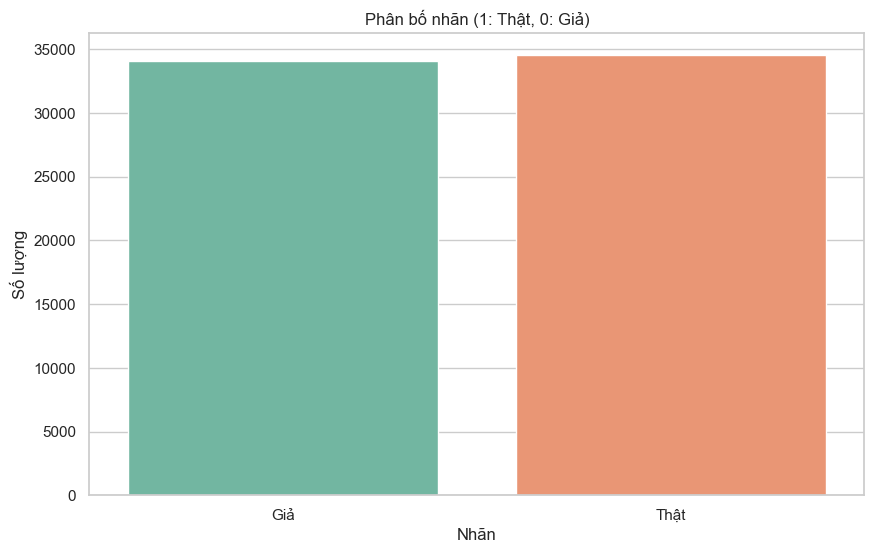

C:\Users\PC\AppData\Local\Temp\ipykernel_20652\3689233907.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='num_words', data=df, palette='Set1')


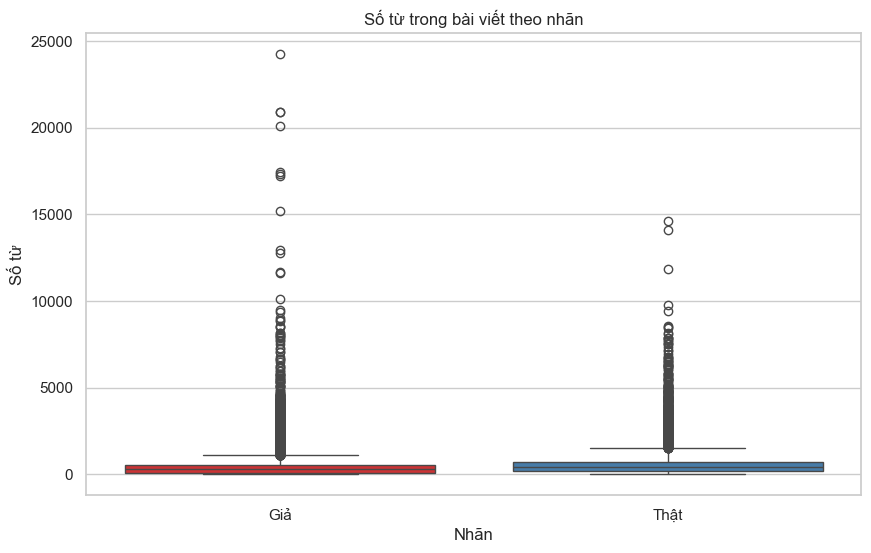

C:\Users\PC\AppData\Local\Temp\ipykernel_20652\3689233907.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='num_chars', data=df, palette='Set3')


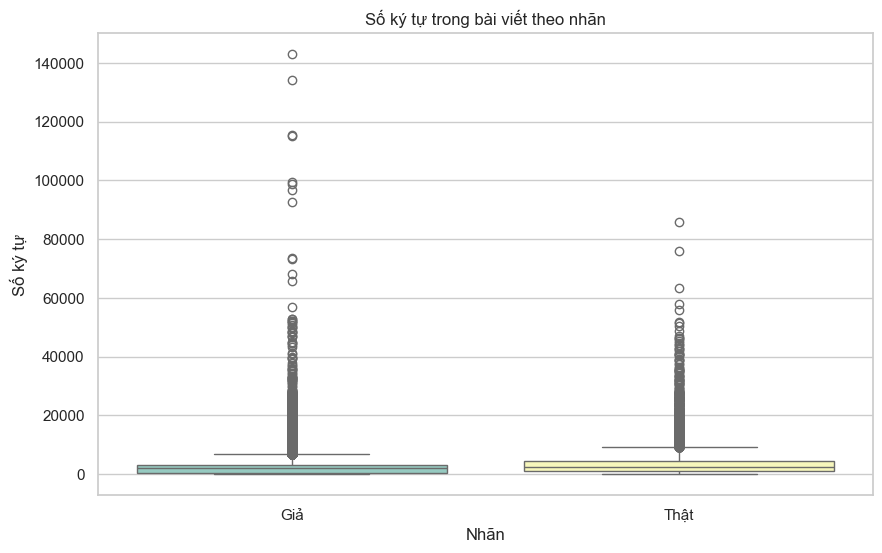

C:\Users\PC\AppData\Local\Temp\ipykernel_20652\3689233907.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='type_token_ratio', data=df, palette='coolwarm')


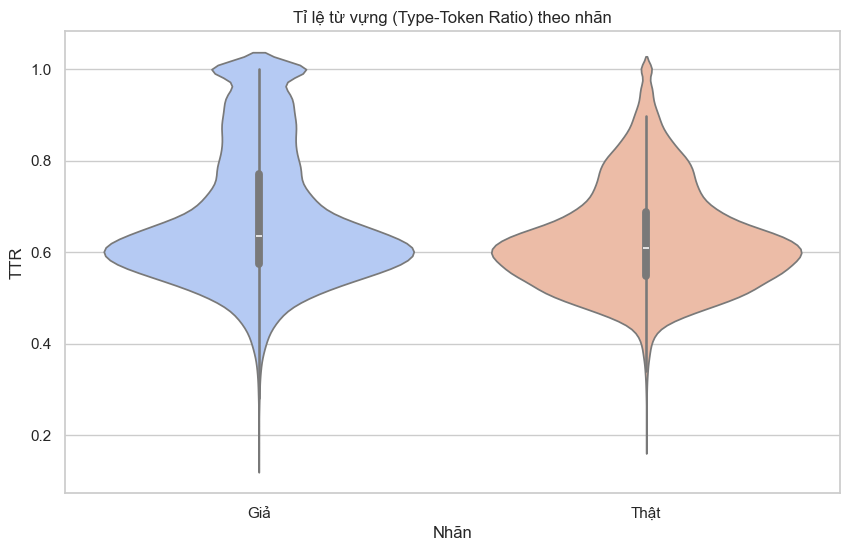

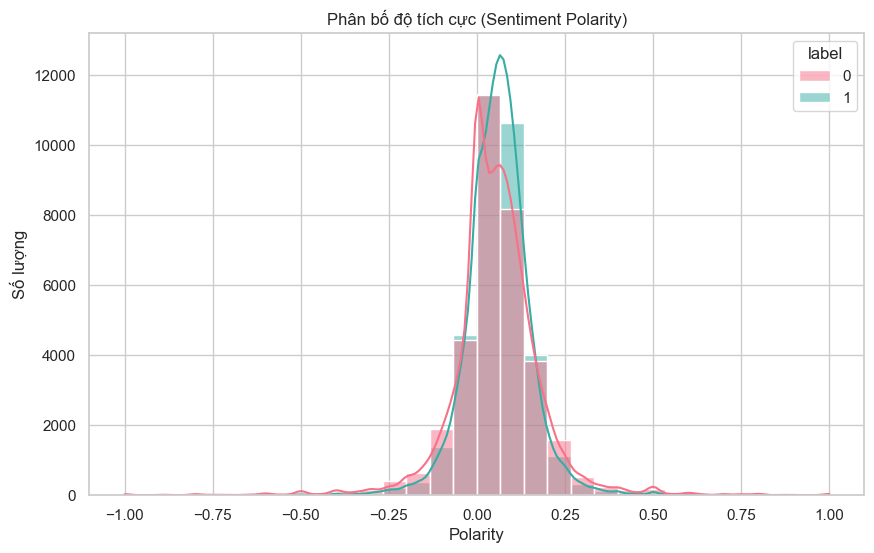

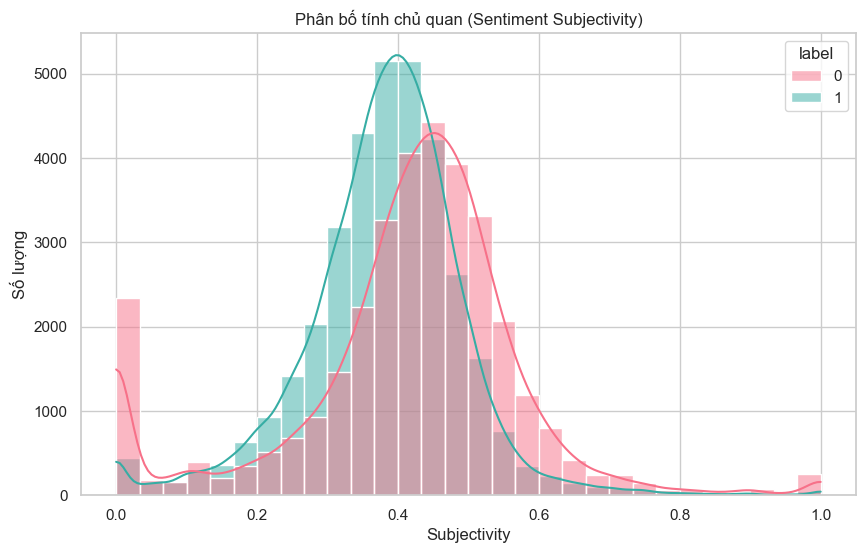

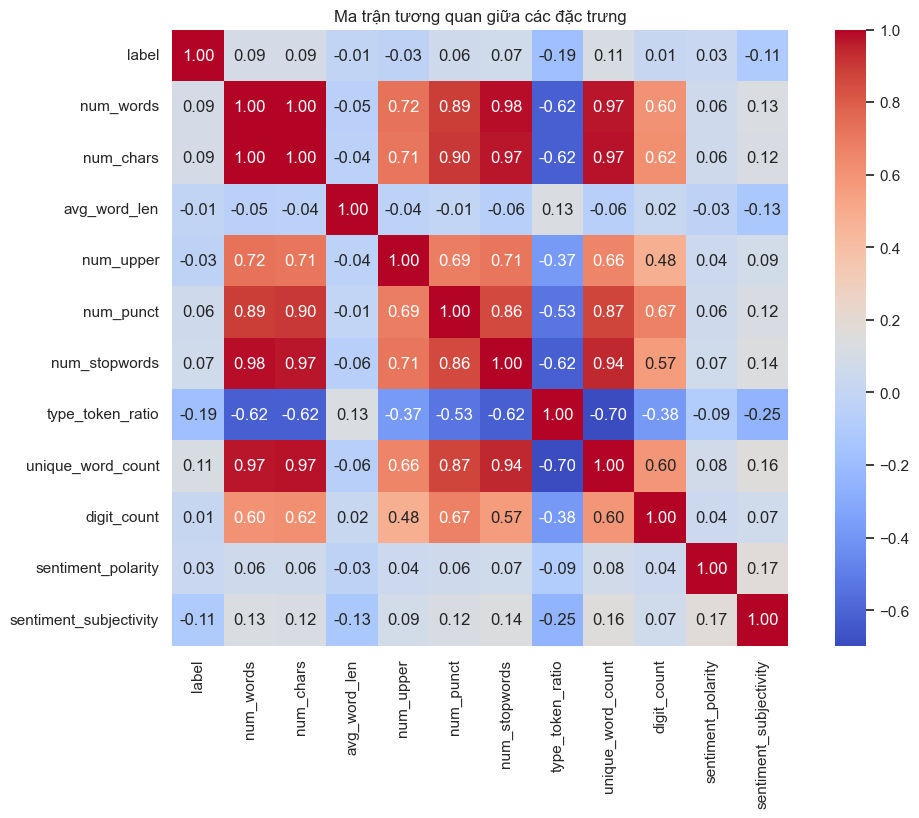

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Biểu đồ phân bố nhãn 
plt.figure()
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Phân bố nhãn (1: Thật, 0: Giả)') # Title correctly states 1 is True, 0 is Fake
plt.xticks([0, 1], ['Giả', 'Thật'])        # xticks map label 0 to 'Giả' and label 1 to 'Thật'
plt.xlabel("Nhãn")
plt.ylabel("Số lượng")
plt.show()

# Boxplot số từ, ký tự
plt.figure()
sns.boxplot(x='label', y='num_words', data=df, palette='Set1')
plt.title('Số từ trong bài viết theo nhãn')
plt.xticks([0, 1], ['Giả', 'Thật'])        # xticks map label 0 to 'Giả' and label 1 to 'Thật'
plt.xlabel("Nhãn")
plt.ylabel("Số từ")
plt.show()

plt.figure()
sns.boxplot(x='label', y='num_chars', data=df, palette='Set3')
plt.title('Số ký tự trong bài viết theo nhãn')
plt.xticks([0, 1], ['Giả', 'Thật'])        # xticks map label 0 to 'Giả' and label 1 to 'Thật'
plt.xlabel("Nhãn")
plt.ylabel("Số ký tự")
plt.show()

# Tỉ lệ từ vựng
plt.figure()
sns.violinplot(x='label', y='type_token_ratio', data=df, palette='coolwarm')
plt.title('Tỉ lệ từ vựng (Type-Token Ratio) theo nhãn')
plt.xticks([0, 1], ['Giả', 'Thật'])        # xticks map label 0 to 'Giả' and label 1 to 'Thật'
plt.xlabel("Nhãn")
plt.ylabel("TTR")
plt.show()

# Phân tích cảm xúc 
plt.figure()
sns.histplot(data=df, x='sentiment_polarity', hue='label', bins=30, kde=True, palette='husl')
plt.title('Phân bố độ tích cực (Sentiment Polarity)')
plt.xlabel("Polarity")
plt.ylabel("Số lượng")
plt.show()

plt.figure()
sns.histplot(data=df, x='sentiment_subjectivity', hue='label', bins=30, kde=True, palette='husl')
plt.title('Phân bố tính chủ quan (Sentiment Subjectivity)')
plt.xlabel("Subjectivity")
plt.ylabel("Số lượng")
plt.show()

# Ma trận tương quan giữa các đặc trưng số
plt.figure(figsize=(12, 8))
correlation = df.drop(columns=['text']).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Ma trận tương quan giữa các đặc trưng")
plt.show()

# **6. Xử lý văn bản và đếm từ**

In [ ]:
import string
import nltk
nltk.download('punkt') # Download the punkt tokenizer
nltk.download('punkt_tab')

# Tiền xử lý văn bản: chuyển về lowercase, xóa dấu câu, loại bỏ stopword, tokenize
def process_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stop_words and w.isalpha()]
    return words


df['processed_text'] = df['text'].apply(process_text)

# Tính tần suất từ xuất hiện theo nhãn
word_freq_true = {}
word_freq_fake = {}

for i, row in df.iterrows():
    for word in row['processed_text']:
        if row['label'] == 1:
            word_freq_true[word] = word_freq_true.get(word, 0) + 1
        else:
            word_freq_fake[word] = word_freq_fake.get(word, 0) + 1

# In top 10 từ phổ biến nhất theo label
print("\n Top 10 từ phổ biến nhất trong tin ĐÚNG:")
sorted_true_words = sorted(word_freq_true.items(), key=lambda x: x[1], reverse=True)[:10]
print(sorted_true_words)

print("\n Top 10 từ phổ biến nhất trong tin GIẢ:")
sorted_fake_words = sorted(word_freq_fake.items(), key=lambda x: x[1], reverse=True)[:10]
print(sorted_fake_words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



 Top 10 từ phổ biến nhất trong tin ĐÚNG:
[('said', 166465), ('trump', 95228), ('mr', 65799), ('would', 56320), ('us', 46374), ('president', 45740), ('one', 38811), ('new', 38622), ('people', 38356), ('state', 33939)]

 Top 10 từ phổ biến nhất trong tin GIẢ:
[('trump', 83650), ('people', 38131), ('us', 36874), ('said', 35386), ('one', 33903), ('would', 33510), ('clinton', 32017), ('president', 27431), ('like', 24344), ('hillary', 22466)]


# **7. WordCloud trực quan hóa từ**

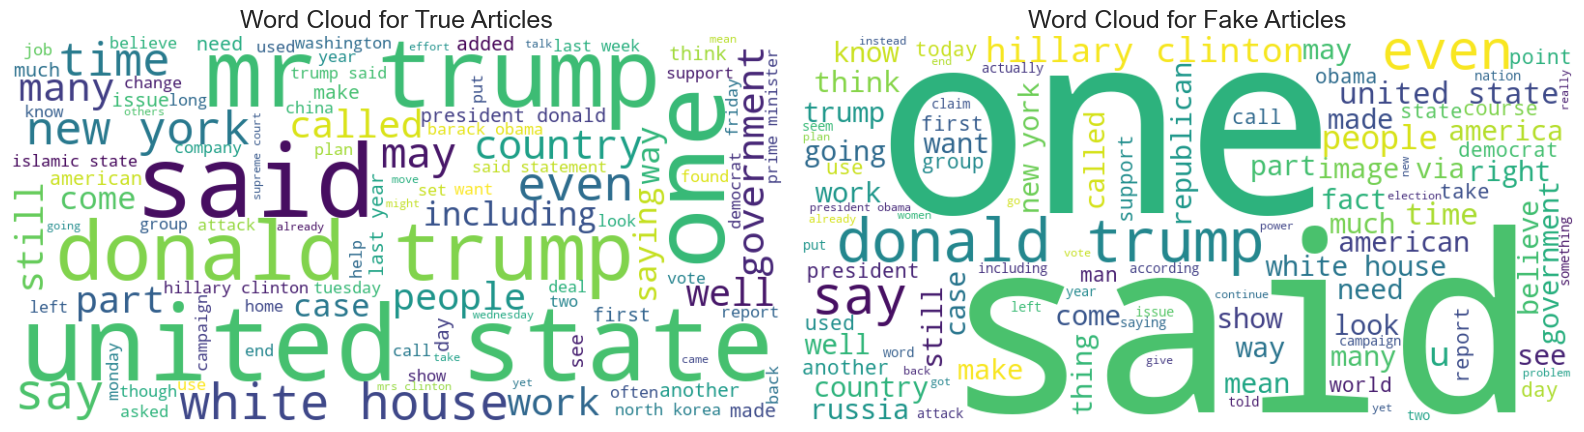

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ghép các từ lại thành 1 chuỗi lớn cho từng loại tin
true_text = ' '.join([' '.join(words) for words in df['processed_text'][df['label'] == 1]])
fake_text = ' '.join([' '.join(words) for words in df['processed_text'][df['label'] == 0]])

# Tạo WordCloud cho từng loại
wordcloud_true = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(true_text)
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(fake_text)

# Hiển thị song song 2 wordcloud
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_true, interpolation='bilinear')
axes[0].set_title("Word Cloud for True Articles", fontsize = 18)
axes[0].axis('off')

axes[1].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].set_title("Word Cloud for Fake Articles", fontsize = 18)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# **6. Phân tích TF-IDF: trích xuất top từ khóa quan trọng nhất trong TRUE và FAKE news**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Tách dữ liệu văn bản theo nhãn (1: thật, 0: giả)
true_texts = df[df['label'] == 1]['text'].dropna().tolist()
fake_texts = df[df['label'] == 0]['text'].dropna().tolist()

# Hàm lấy top N từ có giá trị TF-IDF trung bình cao nhất
def get_top_tfidf_words(corpus, top_n=20):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X = vectorizer.fit_transform(corpus)
    mean_tfidf = X.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    tfidf_scores = list(zip(terms, mean_tfidf))
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:top_n]

# Lấy top 20 từ TF-IDF cho từng loại tin
top_true_words = get_top_tfidf_words(true_texts, top_n=20)
top_fake_words = get_top_tfidf_words(fake_texts, top_n=20)

# In kết quả ra màn hình
print(" Top 20 TF-IDF từ quan trọng trong TRUE News:")
for word, score in top_true_words:
    print(f"{word:<15} {score:.4f}")

print("\n Top 20 TF-IDF từ quan trọng trong FAKE News:")
for word, score in top_fake_words:
    print(f"{word:<15} {score:.4f}")


 Top 20 TF-IDF từ quan trọng trong TRUE News:
said            0.0600
trump           0.0545
mr              0.0332
president       0.0274
state           0.0213
house           0.0199
people          0.0197
clinton         0.0197
new             0.0195
government      0.0181
republican      0.0181
states          0.0173
united          0.0168
party           0.0162
obama           0.0158
year            0.0149
told            0.0146
campaign        0.0145
election        0.0144
white           0.0143

 Top 20 TF-IDF từ quan trọng trong FAKE News:
trump           0.0611
clinton         0.0257
people          0.0229
said            0.0228
president       0.0218
hillary         0.0201
russia          0.0199
obama           0.0174
just            0.0172
donald          0.0167
like            0.0160
new             0.0148
ukraine         0.0143
russian         0.0140
state           0.0137
election        0.0135
time            0.0132
white           0.0130
campaign        0.0128
news      

## **7. Chuẩn bị dữ liệu cho huấn luyện mô hình học máy**

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# Chuyển processed_text (token_list) thành chuỗi để áp dụng TF-IDF
df['processed_text_str'] = df['processed_text'].apply(lambda x: ' '.join(x))

# Khởi tạo TF-IDF Vectorize (tối đa 5000 từ)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Danh sách các đặc trưng đã trích xuất từ trước
engineered_features = ['num_words', 'num_chars', 'avg_word_len', 'num_upper', 'num_punct',
                       'num_stopwords', 'type_token_ratio', 'unique_word_count',
                       'digit_count', 'sentiment_polarity', 'sentiment_subjectivity']

# Tách đầu vào và nhãn
X_text = df['processed_text_str']
X_engineered = df[engineered_features]
y = df['label']


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Tách dữ liệu train/ test
X_text_train, X_text_test, X_eng_train, X_eng_test, y_train, y_test = train_test_split(
    X_text, X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

# Áp dụng TF-IDF cho dữ liệu text
tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
tfidf_test = tfidf_vectorizer.transform(X_text_test)

# Chuẩn hóa các engineer feauture
scaler = StandardScaler()
eng_train_scaled = scaler.fit_transform(X_eng_train)
eng_test_scaled = scaler.transform(X_eng_test)

# Kết hợp đặc trưng: TF-IDF + engineered features
X_train = hstack([tfidf_train, csr_matrix(eng_train_scaled)])
X_test = hstack([tfidf_test, csr_matrix(eng_test_scaled)])

print("Feature processing complete.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



Feature processing complete.
X_train shape: (54883, 5011)
X_test shape: (13721, 5011)
y_train shape: (54883,)
y_test shape: (13721,)


# **8. Random Forest**

Đang train Random Forest demo model...
Model saved to models\random_forest_demo.pkl

Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27262
           1       1.00      1.00      1.00     27621

    accuracy                           1.00     54883
   macro avg       1.00      1.00      1.00     54883
weighted avg       1.00      1.00      1.00     54883

Train report saved to reports\rf_train_report.txt

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6816
           1       0.91      0.94      0.92      6905

    accuracy                           0.92     13721
   macro avg       0.92      0.92      0.92     13721
weighted avg       0.92      0.92      0.92     13721

Test report saved to reports\rf_test_report.txt


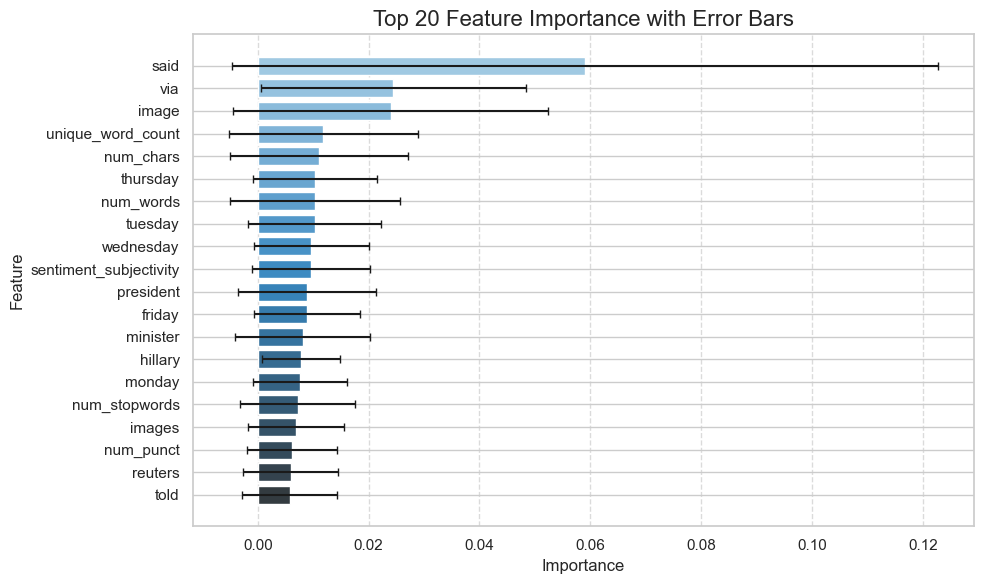

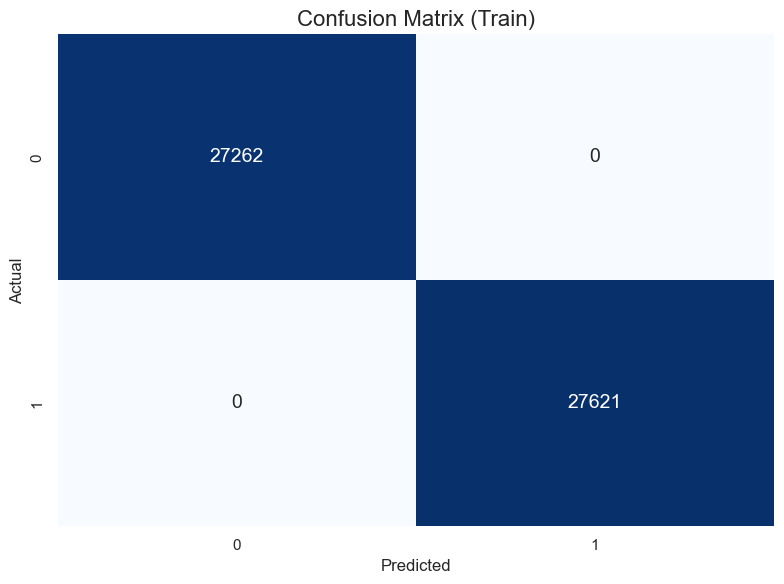

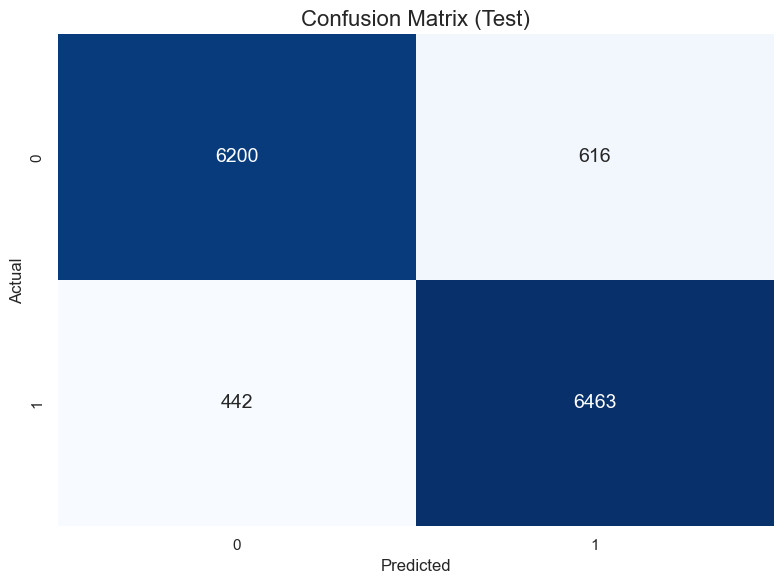

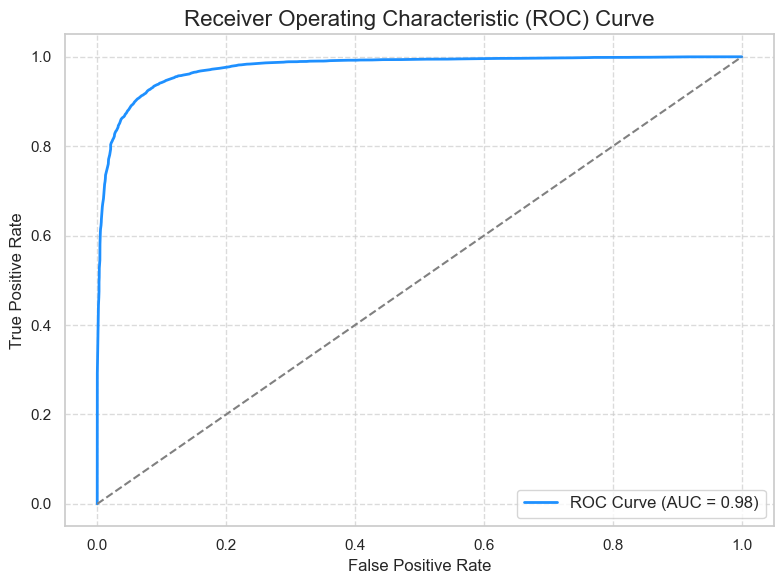

In [ ]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa engineered_features (lấy từ cell xử lý dữ liệu)
engineered_features = ['num_words', 'num_chars', 'avg_word_len', 'num_upper', 'num_punct',
                       'num_stopwords', 'type_token_ratio', 'unique_word_count',
                       'digit_count', 'sentiment_polarity', 'sentiment_subjectivity']

# Đường dẫn lưu model và báo cáo
model_dir = "models"
report_dir = "reports"
rf_model_path = os.path.join(model_dir, "random_forest_demo.pkl")
train_report_path = os.path.join(report_dir, "rf_train_report.txt")
test_report_path = os.path.join(report_dir, "rf_test_report.txt")

# Tạo thư mục nếu chưa tồn tại
os.makedirs(model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# Load model (nếu có), còn không train model mới
if os.path.exists(rf_model_path):
    print("Model Random Forest đã tồn tại. Đang load từ file...")
    rf_model = joblib.load(rf_model_path)
else:
    print("Đang train Random Forest demo model...")
    rf_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    joblib.dump(rf_model, rf_model_path)
    print(f"Model saved to {rf_model_path}")

# Dự đoán và đánh giá
rf_train_preds = rf_model.predict(X_train)
train_report = classification_report(y_train, rf_train_preds)
print("\nClassification Report (Train):")
print(train_report)

with open(train_report_path, "w", encoding="utf-8") as f:
    f.write(train_report)
    print(f"Train report saved to {train_report_path}")

rf_test_preds = rf_model.predict(X_test)
test_report = classification_report(y_test, rf_test_preds)
print("\nClassification Report (Test):")
print(test_report)

with open(test_report_path, "w", encoding="utf-8") as f:
    f.write(test_report)
    print(f"Test report saved to {test_report_path}")

# Trực quan hóa Feature Importance (top 20)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
all_feature_names = np.concatenate([tfidf_feature_names, engineered_features])

feature_importance = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance,
    'Std': std
}).sort_values(by='Importance', ascending=False)

feature_importance_df['Std'] = pd.to_numeric(feature_importance_df['Std'], errors='coerce').fillna(0.0)


# Vẽ biểu đồ feature importance (top 20 với error bars) bằng matplotlib
top_n = 20
feature_importance_df_top = feature_importance_df.head(top_n)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(feature_importance_df_top['Feature'][::-1], feature_importance_df_top['Importance'][::-1],
               xerr=feature_importance_df_top['Std'][::-1], color=sns.color_palette('Blues_d', n_colors=top_n)[::-1],
               capsize=3)
ax.set_title(f'Top {top_n} Feature Importance with Error Bars', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.tight_layout()
plt.show()

# Confusion Matrix
# Tạo confusion matrix cho tập train 
train_cm = confusion_matrix(y_train, rf_train_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix (Train)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# Tạo confusion matrix cho tập test
test_cm = confusion_matrix(y_test, rf_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix (Test)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve + AUC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **9. Decision Tree**

Đang train Decision Tree model demo...
Model saved to models\best_decision_tree_model.joblib

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     27262
           1       0.95      0.96      0.95     27621

    accuracy                           0.95     54883
   macro avg       0.95      0.95      0.95     54883
weighted avg       0.95      0.95      0.95     54883

Train report saved to reports\dt_train_report.txt

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      6816
           1       0.87      0.88      0.87      6905

    accuracy                           0.87     13721
   macro avg       0.87      0.87      0.87     13721
weighted avg       0.87      0.87      0.87     13721

Test report saved to reports\dt_test_report.txt

Feature Importance (Top 10):
        Feature  Importance
3916       said    0.406647
4779  

C:\Users\PC\AppData\Local\Temp\ipykernel_20652\2669420258.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_top, palette='Blues_d')


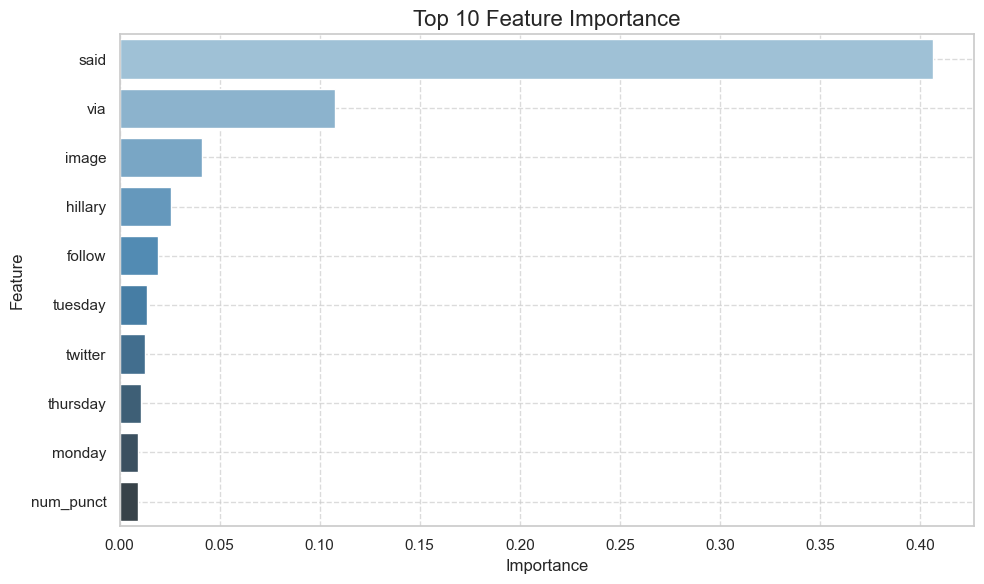

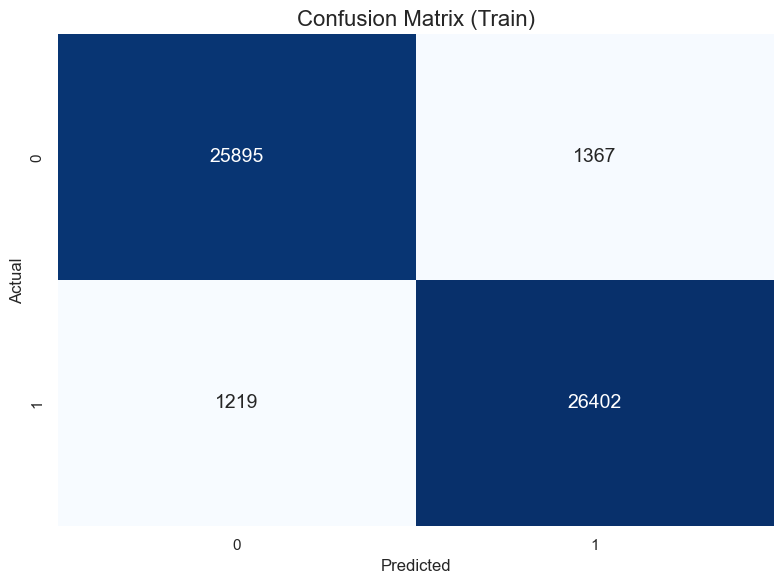

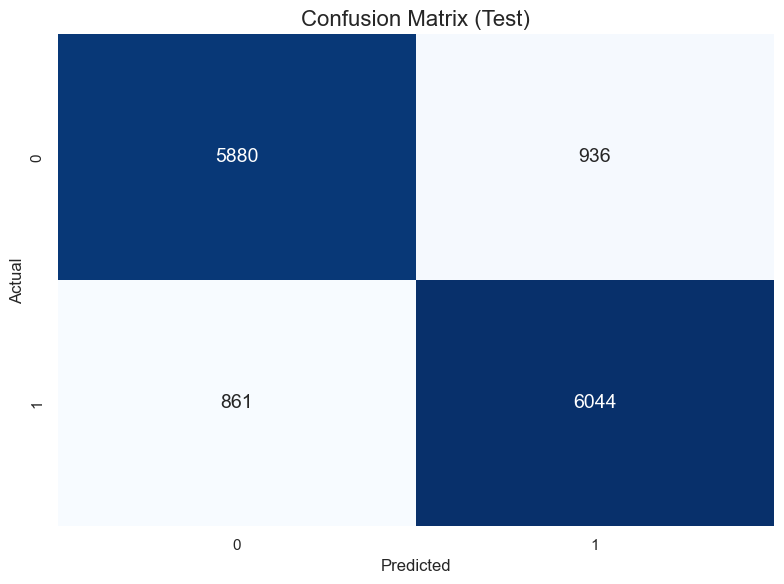

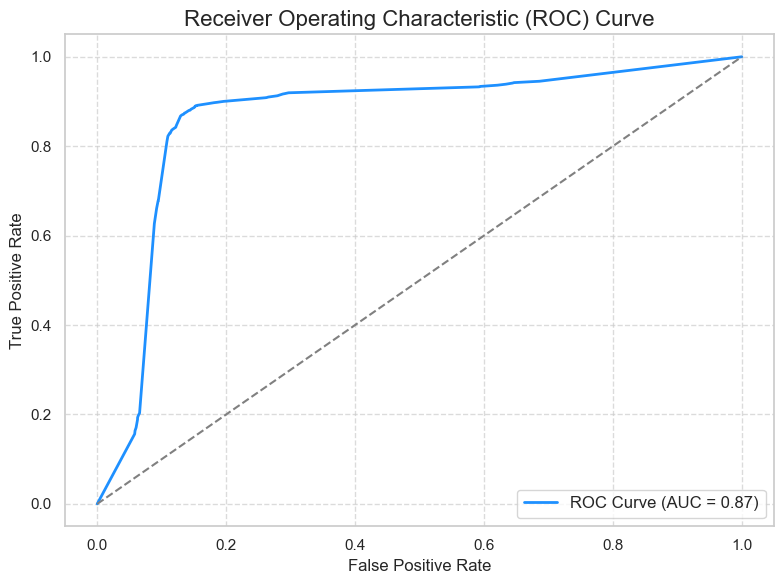

In [ ]:

from sklearn.tree import DecisionTreeClassifier

# Đường dẫn model và báo cáo
model_dir = "models"
report_dir = "reports"
model_path = os.path.join(model_dir, "best_decision_tree_model.joblib")
train_report_path = os.path.join(report_dir, "dt_train_report.txt")
test_report_path = os.path.join(report_dir, "dt_test_report.txt")

# Tạo thư mục nếu chưa có
os.makedirs(model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# Load hoặc train model
if os.path.exists(model_path):
    print("Decision Tree model đã tồn tại. Đang load từ file...")
    best_dt_model = joblib.load(model_path)
else:
    print("Đang train Decision Tree model demo...")
    best_dt_model = DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    best_dt_model.fit(X_train, y_train)
    joblib.dump(best_dt_model, model_path)
    print(f"Model saved to {model_path}")

# Đánh giá trên tập train
dt_train_preds = best_dt_model.predict(X_train)
train_report = classification_report(y_train, dt_train_preds)
print("\nClassification Report (Train):")
print(train_report)

with open(train_report_path, "w", encoding="utf-8") as f:
    f.write(train_report)
    print(f"Train report saved to {train_report_path}")

# Đánh giá trên tập test
dt_test_preds = best_dt_model.predict(X_test)
test_report = classification_report(y_test, dt_test_preds)
print("\nClassification Report (Test):")
print(test_report)

with open(test_report_path, "w", encoding="utf-8") as f:
    f.write(test_report)
    print(f"Test report saved to {test_report_path}")

# In và vẽ Feature Importance 
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
all_feature_names = np.concatenate([tfidf_feature_names, engineered_features])

# Lấy feature importance
feature_importance = best_dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# In top 10 feature importance
print("\nFeature Importance (Top 10):")
print(feature_importance_df.head(10))

# Vẽ biểu đồ feature importance 
top_n = 10
feature_importance_df_top = feature_importance_df.head(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_top, palette='Blues_d')
plt.title(f'Top {top_n} Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Confusion Matrix
# Tạo confusion matrix cho tập train
train_cm = confusion_matrix(y_train, dt_train_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix (Train)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# Tạo confusion matrix cho tập test
test_cm = confusion_matrix(y_test, dt_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix (Test)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve & AUC
y_pred_proba = best_dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **10. XGBoost Classifier**

Training XGBoost demo model...


c:\Users\PC\miniconda3\envs\ML-pytorch-tensorflow-env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:28:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model saved to 'models/xgb_demo_model.joblib'

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27262
           1       1.00      0.99      1.00     27621

    accuracy                           1.00     54883
   macro avg       1.00      1.00      1.00     54883
weighted avg       1.00      1.00      1.00     54883

Train report saved to 'reports/xgb_train_report.txt'

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6816
           1       0.95      0.95      0.95      6905

    accuracy                           0.95     13721
   macro avg       0.95      0.95      0.95     13721
weighted avg       0.95      0.95      0.95     13721

Test report saved to 'reports/xgb_test_report.txt'


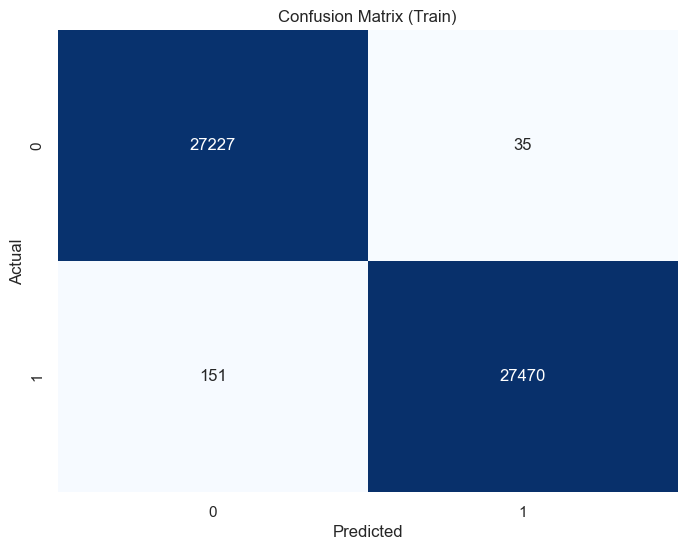

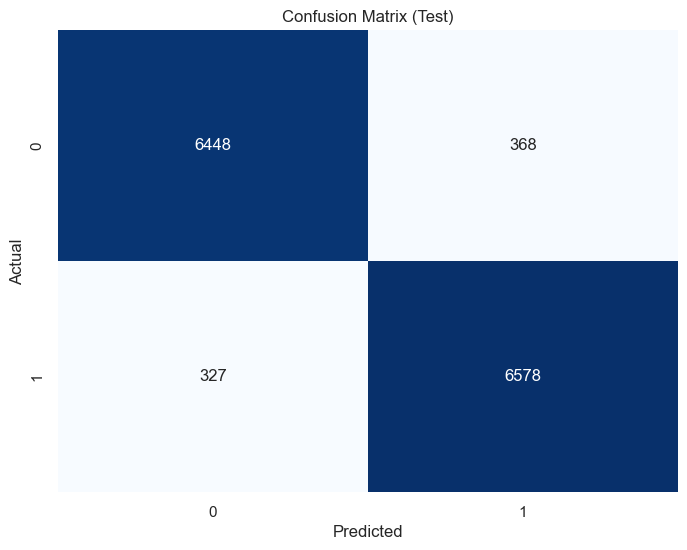

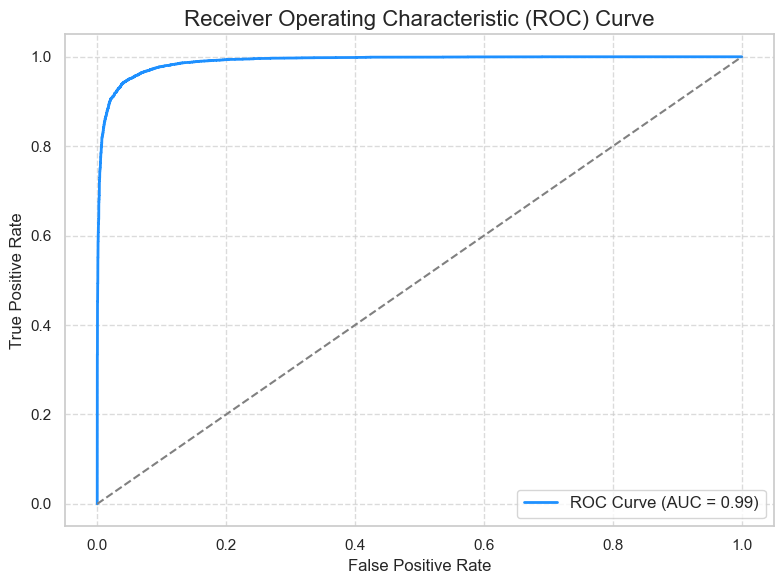

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import numpy as np

# Đường dẫn lưu model & báo cáo
xgb_model_path = 'models/xgb_demo_model.joblib'
train_report_path = 'reports/xgb_train_report.txt'
test_report_path = 'reports/xgb_test_report.txt'


# Tạo thư mục models và reports nếu chưa tồn tại 
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# Load model từ file nếu đã tồn tại, nếu không huấn luyện mới
if os.path.exists(xgb_model_path):
    print("XGBoost demo model đã tồn tại. Đang load từ file...")
    xgb_model = joblib.load(xgb_model_path)
else:
    print("Training XGBoost demo model...")
    xgb_model = XGBClassifier(
        n_estimators=1000,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,          # giảm overfitting
        colsample_bytree=0.8,   # giảm overfitting
        gamma=1,                # pruning
        reg_alpha=1,            # L1 regularization
        reg_lambda=1,           # L2 regularization
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    joblib.dump(xgb_model, xgb_model_path)
    print(f"XGBoost model saved to '{xgb_model_path}'")

# Dự đoán tập train
xgb_train_preds = xgb_model.predict(X_train)
train_report = classification_report(y_train, xgb_train_preds)
print("\nClassification Report (Train):")
print(train_report)
with open(train_report_path, "w", encoding="utf-8") as f:
    f.write(train_report)
    print(f"Train report saved to '{train_report_path}'")

# Dự đoán tập test
xgb_test_preds = xgb_model.predict(X_test)
test_report = classification_report(y_test, xgb_test_preds)
print("\nClassification Report (Test):")
print(test_report)
with open(test_report_path, "w", encoding="utf-8") as f:
    f.write(test_report)
    print(f"Test report saved to '{test_report_path}'")

# Confusion Matrix
# Tạo confusion matrix cho tập train
train_cm = confusion_matrix(y_train, xgb_train_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Tạo confusion matrix cho tập test
test_cm = confusion_matrix(y_test, xgb_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ROC CURVE VÀ AUC
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Tính toán FPR, TPR, AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5) # Đường tham chiếu
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **11. Logistic Regression**

Training Logistic Regression model...
Model saved to 'models\logistic_regression_model.joblib'

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     27262
           1       0.95      0.94      0.95     27621

    accuracy                           0.95     54883
   macro avg       0.95      0.95      0.95     54883
weighted avg       0.95      0.95      0.95     54883

Train report saved to 'reports\lr_train_report.txt'

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6816
           1       0.94      0.93      0.93      6905

    accuracy                           0.93     13721
   macro avg       0.93      0.93      0.93     13721
weighted avg       0.93      0.93      0.93     13721

Test report saved to 'reports\lr_test_report.txt'


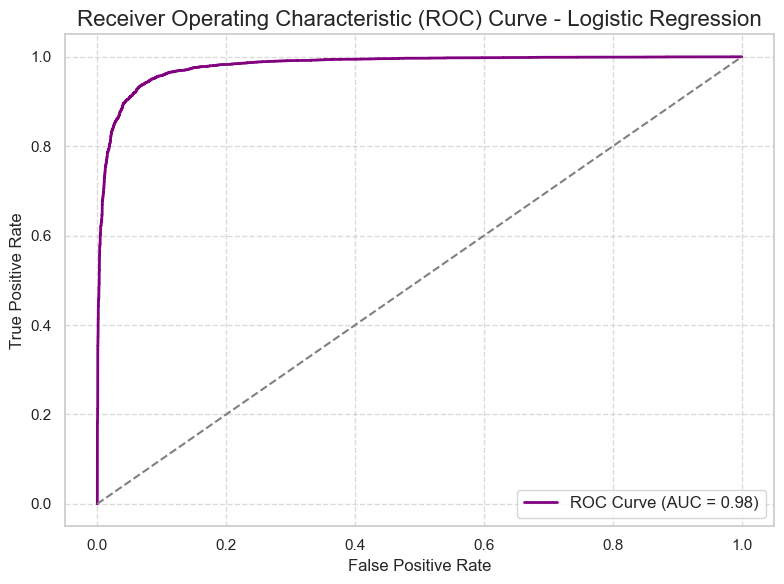

In [ ]:
from sklearn.linear_model import LogisticRegression

# Đường dẫn lưu model và báo cáo
model_dir = "models"
report_dir = "reports"
lr_model_path = os.path.join(model_dir, "logistic_regression_model.joblib")
train_report_path = os.path.join(report_dir, "lr_train_report.txt")
test_report_path = os.path.join(report_dir, "lr_test_report.txt")

# Tạo thư mục nếu chưa có
os.makedirs(model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# Load hoặc train model Logistic Regression
if os.path.exists(lr_model_path):
    print("Logistic Regression model đã tồn tại. Đang load từ file...")
    lr_model = joblib.load(lr_model_path)
else:
    print("Training Logistic Regression model...")

    # Cấu hình logistic regression
    lr_model = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
    lr_model.fit(X_train, y_train)

    # Lưu model
    joblib.dump(lr_model, lr_model_path)
    print(f"Model saved to '{lr_model_path}'")

# Đánh giá trên tập train
lr_train_preds = lr_model.predict(X_train)
train_report = classification_report(y_train, lr_train_preds)
print("\nClassification Report (Train):")
print(train_report)

with open(train_report_path, "w", encoding="utf-8") as f:
    f.write(train_report)
    print(f"Train report saved to '{train_report_path}'")

# Đánh giá trên tập test 
lr_test_preds = lr_model.predict(X_test)
test_report = classification_report(y_test, lr_test_preds)
print("\nClassification Report (Test):")
print(test_report)

with open(test_report_path, "w", encoding="utf-8") as f:
    f.write(test_report)
    print(f"Test report saved to '{test_report_path}'")

# VẼ ROC CURVE VÀ AUC
# Lấy xác suất dự đoán cho lớp 1 (positive class) trên tập test
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Tính toán False Positive Rate (FPR), True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Vẽ biểu đồ ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **12. RNN model with LTSM**

GPU Availability Check:
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU detected: NVIDIA GeForce RTX 3060 Laptop GPU
GPU memory: 6.4 GB

Loading dataset...
Preprocessing text data...
Dataset shape after preprocessing: (68495, 3)
Label distribution:
label
1    34524
0    33971
Name: count, dtype: int64

Splitting dataset...
Training set size: 47946
Validation set size: 10274
Test set size: 10275
Building vocabulary...
Vocabulary size: 10000
Creating data loaders...

Training model...
Building model...

Model Architecture:
LSTMClassifier(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 1,489,025

Starting training for 20 epochs...


Epoch 1/20 [Val]: 100%|██████████| 322/322 [00:03<00:00, 100.31it/s, Loss=0.0164]


Epoch 1/20:
  Train Loss: 0.2813, Train Acc: 0.8873
  Val Loss: 0.1824, Val Acc: 0.9306
  Train P/R: 0.8924/0.8828, Val P/R: 0.9235/0.9401


Epoch 2/20 [Val]: 100%|██████████| 322/322 [00:03<00:00, 88.62it/s, Loss=0.0057]


Epoch 2/20:
  Train Loss: 0.1550, Train Acc: 0.9466
  Val Loss: 0.1820, Val Acc: 0.9345
  Train P/R: 0.9496/0.9442, Val P/R: 0.9535/0.9146


Epoch 3/20 [Val]: 100%|██████████| 322/322 [00:03<00:00, 95.53it/s, Loss=0.4125] 


Epoch 3/20:
  Train Loss: 0.1094, Train Acc: 0.9644
  Val Loss: 0.1913, Val Acc: 0.9354
  Train P/R: 0.9657/0.9637, Val P/R: 0.9512/0.9189


Epoch 4/20 [Val]: 100%|██████████| 322/322 [00:03<00:00, 98.48it/s, Loss=1.3754] 


Epoch 4/20:
  Train Loss: 0.0727, Train Acc: 0.9762
  Val Loss: 0.2295, Val Acc: 0.9384
  Train P/R: 0.9782/0.9745, Val P/R: 0.9555/0.9206


Epoch 5/20 [Val]: 100%|██████████| 322/322 [00:03<00:00, 90.10it/s, Loss=0.0007] 


Epoch 5/20:
  Train Loss: 0.0519, Train Acc: 0.9838
  Val Loss: 0.2720, Val Acc: 0.9358
  Train P/R: 0.9839/0.9840, Val P/R: 0.9145/0.9625


Epoch 6/20 [Val]: 100%|██████████| 322/322 [00:03<00:00, 97.86it/s, Loss=0.0008] 


Epoch 6/20:
  Train Loss: 0.0376, Train Acc: 0.9887
  Val Loss: 0.2695, Val Acc: 0.9377
  Train P/R: 0.9892/0.9882, Val P/R: 0.9260/0.9525


Epoch 7/20 [Val]: 100%|██████████| 322/322 [00:03<00:00, 96.92it/s, Loss=0.1381] 


Epoch 7/20:
  Train Loss: 0.0166, Train Acc: 0.9953
  Val Loss: 0.3131, Val Acc: 0.9474
  Train P/R: 0.9950/0.9956, Val P/R: 0.9512/0.9442
Early stopping triggered after 7 epochs

Evaluating model...


Evaluating: 100%|██████████| 322/322 [00:02<00:00, 119.00it/s]



MODEL PERFORMANCE METRICS
Accuracy:  0.9304
Precision: 0.9583
Recall:    0.9011
F1-Score:  0.9288

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Fake News       0.91      0.96      0.93      5096
   Real News       0.96      0.90      0.93      5179

    accuracy                           0.93     10275
   macro avg       0.93      0.93      0.93     10275
weighted avg       0.93      0.93      0.93     10275



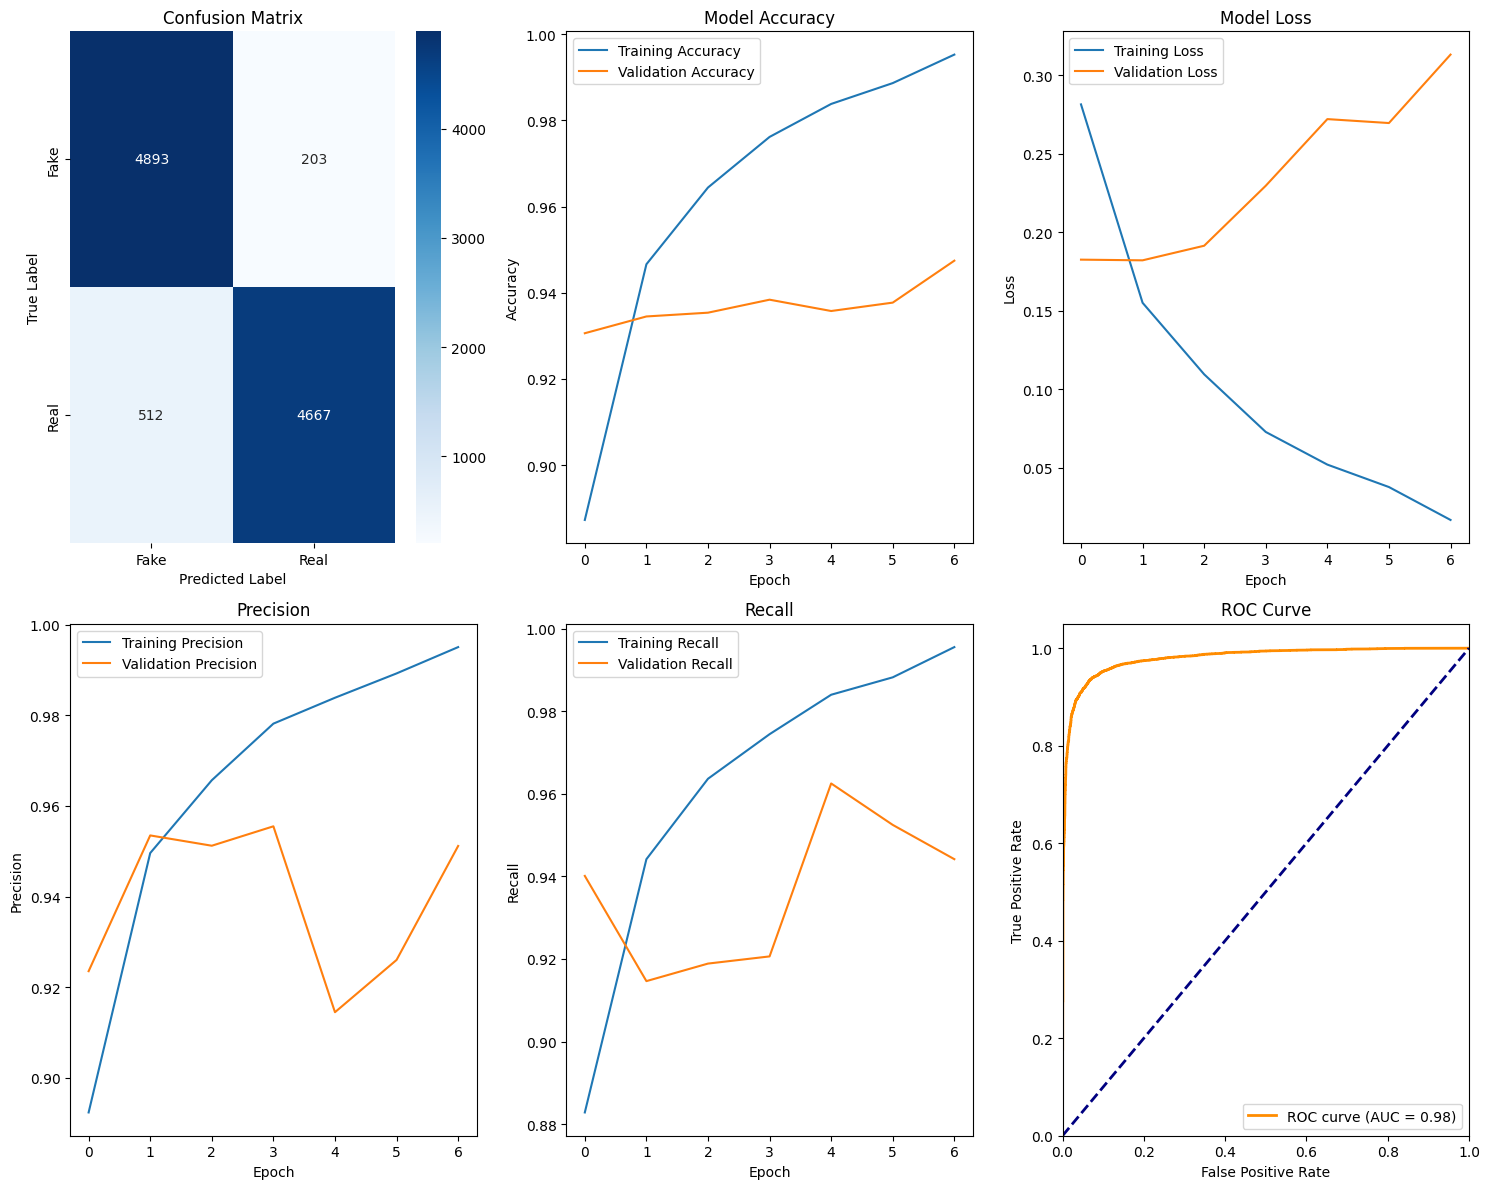

Model saved to fake_news_classifier.pth

EXAMPLE PREDICTIONS

Text: luhansk people republic independent state...
True label: Fake News
Prediction: Fake News
Confidence: 0.9865

Text: democratic primary wrap hillary clinton slated clinch majority pledged delegate thus reach total amo...
True label: Fake News
Prediction: Fake News
Confidence: 0.9792

Text: bond save russian spy andrew parker head british counterintelligence servive claimed russia growing ...
True label: Fake News
Prediction: Fake News
Confidence: 0.9897


In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Tải dữ liệu NLTK cần thiết cho xử lý ngôn ngữ
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Dataset Class cho Text Data
class TextDataset(Dataset):
    """Custom Dataset class for text data"""
    def __init__(self, texts, labels, vocab_to_int, max_length):
        self.texts = texts
        self.labels = labels
        self.vocab_to_int = vocab_to_int
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Chuyển text thành chuỗi số nguyên (token id)
        tokens = text.split()
        sequence = [self.vocab_to_int.get(token, self.vocab_to_int['<UNK>']) for token in tokens]
        
        # Padding hoặc cắt bớt
        if len(sequence) < self.max_length:
            sequence.extend([self.vocab_to_int['<PAD>']] * (self.max_length - len(sequence)))
        else:
            sequence = sequence[:self.max_length]
        
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# Mô hình LSTM Classifier
class LSTMClassifier(nn.Module):
    """LSTM-based fake news classifier"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Lớp embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM 2 chiều (bidirectional)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True, 
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout & fully connected layers
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # *2 for bidirectional
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        # Khởi tạo trọng số mạng
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.kaiming_uniform_(param, nonlinearity='relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.dropout(hidden)
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = F.relu(self.fc2(output))
        output = self.dropout(output)
        output = torch.sigmoid(self.fc3(output))
        return output.squeeze()

# Class quản lý quy trình huấn luyện
class FakeNewsClassifierPyTorch:
    def __init__(self, max_features=10000, max_length=500, embedding_dim=128, hidden_dim=64):
        self.max_features = max_features
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_to_int = {}
        self.int_to_vocab = {}
        self.model = None
        self.device = None
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def check_gpu(self):
        # Kiểm tra và thiết lập GPU nếu có
        print("GPU Availability Check:")
        print(f"PyTorch version: {torch.__version__}")
        print(f"CUDA available: {torch.cuda.is_available()}")
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            print(f"GPU detected: {torch.cuda.get_device_name(0)}")
            print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        else:
            self.device = torch.device('cpu')
            print("No GPU detected. Using CPU.")
        
        return self.device
    
    def preprocess_text(self, text):
        # Làm sạch và chuẩn hóa văn bản
        if pd.isna(text):
            return ""
        text = text.lower()  
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        return ' '.join(tokens)
    
    def prepare_data(self, df, text_column='text', label_column='label'):
        # Xử lý văn bản và loại bỏ dòng rỗng
        print("Preprocessing text data...")
        df_processed = df.copy()
        df_processed['processed_text'] = df_processed[text_column].apply(self.preprocess_text)
        df_processed = df_processed[df_processed['processed_text'].str.len() > 0]
        print(f"Dataset shape after preprocessing: {df_processed.shape}")
        print(f"Label distribution:\n{df_processed[label_column].value_counts()}")
        return df_processed
    
    def build_vocabulary(self, texts):
        # Xây dựng từ điển (vocab) từ tập huấn luyện
        print("Building vocabulary...")
        word_counts = Counter()
        for text in texts:
            word_counts.update(text.split())
        most_common = word_counts.most_common(self.max_features - 3)  # Reserve 3 for special tokens
        self.vocab_to_int = {'<PAD>': 0, '<UNK>': 1, '<START>': 2}
        self.int_to_vocab = {0: '<PAD>', 1: '<UNK>', 2: '<START>'}
        for i, (word, _) in enumerate(most_common):
            self.vocab_to_int[word] = i + 3
            self.int_to_vocab[i + 3] = word
        print(f"Vocabulary size: {len(self.vocab_to_int)}")
        return self.vocab_to_int
    
    def create_data_loaders(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
        # Tạo Dataloder cho huấn luyện, validation, test
        print("Creating data loaders...")
        train_dataset = TextDataset(X_train, y_train, self.vocab_to_int, self.max_length)
        val_dataset = TextDataset(X_val, y_val, self.vocab_to_int, self.max_length)
        test_dataset = TextDataset(X_test, y_test, self.vocab_to_int, self.max_length)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        return train_loader, val_loader, test_loader
    
    def build_model(self):
        # Xây dựng mô hình LSTM
        vocab_size = len(self.vocab_to_int)
        
        model = LSTMClassifier(
            vocab_size=vocab_size,
            embedding_dim=self.embedding_dim,
            hidden_dim=self.hidden_dim,
            num_layers=2,
            dropout=0.3
        )
        
        return model.to(self.device)
    
    def train_model(self, train_loader, val_loader, epochs=20, learning_rate=0.001):
        # Huấn luyện mô hình LSTM
        print("Building model...")
        self.model = self.build_model()
        
        print(f"\nModel Architecture:")
        print(self.model)
        print(f"Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        # Hàm mất mát & bộ tối ưu
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
        
        # Lịch sử huấn luyện
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'train_precision': [], 'train_recall': [],
            'val_precision': [], 'val_recall': []
        }
        
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 5
        
        print(f"\nStarting training for {epochs} epochs...")
        
        for epoch in range(epochs):
            # Các pha huấn luyện
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            train_preds = []
            train_labels = []
            
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
            for batch_texts, batch_labels in train_pbar:
                batch_texts, batch_labels = batch_texts.to(self.device), batch_labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_texts)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                
                # Cắt gradient để tránh gradient exploding
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_loss += loss.item()
                predicted = (outputs > 0.5).float()
                train_total += batch_labels.size(0)
                train_correct += (predicted == batch_labels).sum().item()
                
                train_preds.extend(predicted.cpu().numpy())
                train_labels.extend(batch_labels.cpu().numpy())
                
                train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
            # Tính độ chính xác, precision, recall
            train_accuracy = train_correct / train_total
            train_precision, train_recall, _, _ = precision_recall_fscore_support(
                train_labels, train_preds, average='binary', zero_division=0
            )
            
            # Pha Validation 
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_preds = []
            val_labels = []
            
            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
                for batch_texts, batch_labels in val_pbar:
                    batch_texts, batch_labels = batch_texts.to(self.device), batch_labels.to(self.device)
                    
                    outputs = self.model(batch_texts)
                    loss = criterion(outputs, batch_labels)
                    
                    val_loss += loss.item()
                    predicted = (outputs > 0.5).float()
                    val_total += batch_labels.size(0)
                    val_correct += (predicted == batch_labels).sum().item()
                    
                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(batch_labels.cpu().numpy())
                    
                    val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
            val_accuracy = val_correct / val_total
            val_precision, val_recall, _, _ = precision_recall_fscore_support(
                val_labels, val_preds, average='binary', zero_division=0
            )
            
            # Cập nhật lịch sử
            history['train_loss'].append(train_loss / len(train_loader))
            history['train_acc'].append(train_accuracy)
            history['val_loss'].append(val_loss / len(val_loader))
            history['val_acc'].append(val_accuracy)
            history['train_precision'].append(train_precision)
            history['train_recall'].append(train_recall)
            history['val_precision'].append(val_precision)
            history['val_recall'].append(val_recall)
            
            # In kết quả epoch
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}')
            print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.4f}')
            print(f'  Train P/R: {train_precision:.4f}/{train_recall:.4f}, Val P/R: {val_precision:.4f}/{val_recall:.4f}')
            
            scheduler.step(val_loss / len(val_loader))
            
            # Lưu mô hình tốt nhất
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping triggered after {epoch+1} epochs')
                    break
        
        # Load lại mô hình tốt nhất
        self.model.load_state_dict(torch.load('best_model.pth'))
        self.history = history
        
        return history
    
    def evaluate_model(self, test_loader):
        """Evaluate the model and display comprehensive metrics"""
        print("\nEvaluating model...")
        
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch_texts, batch_labels in tqdm(test_loader, desc='Evaluating'):
                batch_texts, batch_labels = batch_texts.to(self.device), batch_labels.to(self.device)
                
                outputs = self.model(batch_texts)
                predicted = (outputs > 0.5).float()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
        
        # Convert to numpy arrays
        y_test = np.array(all_labels)
        y_pred = np.array(all_preds)
        y_prob = np.array(all_probs)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        
        print(f"\n{'='*50}")
        print(f"MODEL PERFORMANCE METRICS")
        print(f"{'='*50}")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        
        # Detailed classification report
        print(f"\n{'='*50}")
        print(f"DETAILED CLASSIFICATION REPORT")
        print(f"{'='*50}")
        print(classification_report(y_test, y_pred, target_names=['Fake News', 'Real News']))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot results
        plt.figure(figsize=(15, 12))
        
        # Confusion Matrix
        plt.subplot(2, 3, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # Training history plots
        if hasattr(self, 'history'):
            plt.subplot(2, 3, 2)
            plt.plot(self.history['train_acc'], label='Training Accuracy')
            plt.plot(self.history['val_acc'], label='Validation Accuracy')
            plt.title('Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            plt.subplot(2, 3, 3)
            plt.plot(self.history['train_loss'], label='Training Loss')
            plt.plot(self.history['val_loss'], label='Validation Loss')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.subplot(2, 3, 4)
            plt.plot(self.history['train_precision'], label='Training Precision')
            plt.plot(self.history['val_precision'], label='Validation Precision')
            plt.title('Precision')
            plt.xlabel('Epoch')
            plt.ylabel('Precision')
            plt.legend()
            
            plt.subplot(2, 3, 5)
            plt.plot(self.history['train_recall'], label='Training Recall')
            plt.plot(self.history['val_recall'], label='Validation Recall')
            plt.title('Recall')
            plt.xlabel('Epoch')
            plt.ylabel('Recall')
            plt.legend()
            
            # ROC Curve
            plt.subplot(2, 3, 6)
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.show()
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred,
            'probabilities': y_prob
        }
    
    def predict_single(self, text):
        """Predict a single text"""
        self.model.eval()
        
        # Preprocess text
        processed_text = self.preprocess_text(text)
        
        # Convert to sequence
        tokens = processed_text.split()
        sequence = [self.vocab_to_int.get(token, self.vocab_to_int['<UNK>']) for token in tokens]
        
        # Pad or truncate
        if len(sequence) < self.max_length:
            sequence.extend([self.vocab_to_int['<PAD>']] * (self.max_length - len(sequence)))
        else:
            sequence = sequence[:self.max_length]
        
        # Convert to tensor
        sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(self.device)
        
        with torch.no_grad():
            probability = self.model(sequence_tensor).item()
            prediction = int(probability > 0.5)
        
        return {
            'prediction': 'Real News' if prediction == 1 else 'Fake News',
            'confidence': max(probability, 1 - probability),
            'probability_real': probability
        }
    
    def save_model(self, filepath):
        """Save the trained model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'vocab_to_int': self.vocab_to_int,
            'int_to_vocab': self.int_to_vocab,
            'max_length': self.max_length,
            'embedding_dim': self.embedding_dim,
            'hidden_dim': self.hidden_dim
        }, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model"""
        checkpoint = torch.load(filepath, map_location=self.device)
        
        self.vocab_to_int = checkpoint['vocab_to_int']
        self.int_to_vocab = checkpoint['int_to_vocab']
        self.max_length = checkpoint['max_length']
        self.embedding_dim = checkpoint['embedding_dim']
        self.hidden_dim = checkpoint['hidden_dim']
        
        self.model = self.build_model()
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        print(f"Model loaded from {filepath}")

def main():
    """Main function to run the fake news classifier"""
    
    # Initialize classifier
    classifier = FakeNewsClassifierPyTorch(
        max_features=10000, 
        max_length=500, 
        embedding_dim=128, 
        hidden_dim=64
    )
    
    # Check GPU availability
    device = classifier.check_gpu()
    
    # Load your data
    print("\nLoading dataset...")
    
    # For demonstration, let's assume df_rnn is already loaded
    if 'df_rnn' not in globals():
        print("Error: df_rnn not found. Please ensure your dataset is loaded.")
        print("Your dataset should have columns:")
        print("- 'text': unprocessed text column")
        print("- 'label': 1 for real news, 0 for fake news")
        return
    
    # Prepare data
    df_processed = classifier.prepare_data(df_rnn, text_column='text', label_column='label')
    
    # Split data
    print("\nSplitting dataset...")
    X = df_processed['processed_text'].values
    y = df_processed['label'].values
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    # Build vocabulary
    classifier.build_vocabulary(X_train)
    
    # Create data loaders
    train_loader, val_loader, test_loader = classifier.create_data_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32
    )
    
    # Train model
    print("\nTraining model...")
    history = classifier.train_model(
        train_loader, val_loader,
        epochs=20,
        learning_rate=0.001
    )
    
    # Evaluate model
    results = classifier.evaluate_model(test_loader)
    
    # Save model
    classifier.save_model('fake_news_classifier.pth')
    
    # Example predictions
    print(f"\n{'='*50}")
    print(f"EXAMPLE PREDICTIONS")
    print(f"{'='*50}")
    
    # Test with some examples
    for i in range(min(3, len(X_test))):
        result = classifier.predict_single(X_test[i])
        print(f"\nText: {X_test[i][:100]}...")
        print(f"True label: {'Real News' if y_test[i] == 1 else 'Fake News'}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.4f}")
    
    return classifier, results

# Example usage
if __name__ == "__main__":
    # Run the classifier
    classifier, results = main()
    
    # You can now use the classifier for predictions:
    # result = classifier.predict_single("Your news text here")
    # print(result)

# **13. BERT**

In [7]:
import os
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset, load_from_disk
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
#Prepare inference sample and split data
def split_dataframe(df, train_size=0.7, val_size=0.1, test_size=0.2, random_state=50):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-5
    df_train, df_tmp = train_test_split(
        df, test_size=(1 - train_size), stratify=df['label'], random_state=random_state
    )
    relative_val_size = val_size / (val_size + test_size)
    df_val, df_test = train_test_split(
        df_tmp, test_size=(1 - relative_val_size), stratify=df_tmp['label'], random_state=random_state
    )
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)



df_train, df_val, df_test = split_dataframe(df_deeplearning, train_size=0.7, val_size=0.15, test_size=0.15, random_state=50)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 48022, Val: 10291, Test: 10291


In [9]:
def df_to_hf_dataset(df):
    # Only keep the necessary columns and convert to Dataset
    df_subset = df[['text', 'label']].reset_index(drop=True)
    return Dataset.from_pandas(df_subset)

train_dataset = df_to_hf_dataset(df_train)
val_dataset = df_to_hf_dataset(df_val)
test_dataset = df_to_hf_dataset(df_test)

In [10]:

def tokenize_hf_dataset(dataset, tokenizer, max_length=128):
    def tokenize_fn(example):
        return tokenizer(
            example["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        )
    return dataset.map(tokenize_fn, batched=True)


In [11]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

def get_trainer(
    model_name,
    train_tokenized,
    val_tokenized,
    num_labels,
    output_dir,
    epochs=2,
    batch_size=24,
    metric_for_best_model="eval_loss",
    fp16=True,
):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model=metric_for_best_model,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        fp16=fp16 and torch.cuda.is_available(),
        report_to="none",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        compute_metrics=compute_metrics,  # <-- Ensure this is set
    )
    return trainer
def load_or_train(trainer, output_dir):
    # Resume from latest checkpoint if available
    if os.path.exists(output_dir):
        checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
        if checkpoints:
            latest_ckpt = os.path.join(output_dir, sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))[-1])
            print(f"Loading from checkpoint: {latest_ckpt}")
            trainer.train(resume_from_checkpoint=latest_ckpt)
            return
    print("No checkpoint found, starting training from scratch.")
    trainer.train()

In [12]:
import matplotlib.pyplot as plt

def plot_loss(output_dir, title="Loss and Metrics"):
    import json
    with open(os.path.join(output_dir, "trainer_state.json")) as f:
        state = json.load(f)
    logs = state["log_history"]
    epochs = [x["epoch"] for x in logs if "eval_loss" in x]
    eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]
    eval_acc = [x.get("eval_accuracy") for x in logs if "eval_accuracy" in x]
    eval_f1 = [x.get("eval_f1") for x in logs if "eval_f1" in x]
    eval_precision = [x.get("eval_precision") for x in logs if "eval_precision" in x]
    eval_recall = [x.get("eval_recall") for x in logs if "eval_recall" in x]

    plt.figure(figsize=(10,6))
    plt.plot(epochs, eval_loss, label="Validation Loss")
    plt.plot(epochs, eval_acc, label="Accuracy")
    plt.plot(epochs, eval_f1, label="F1 Score")
    plt.plot(epochs, eval_precision, label="Precision")
    plt.plot(epochs, eval_recall, label="Recall")
    plt.xlabel("Epoch")
    plt.title(title)
    plt.legend()
    plt.show()

In [13]:
def run_inference(model_dir, texts, batch_size=32):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
    model.eval()
    results = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_enc = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
            logits = model(**batch_enc).logits
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=-1).cpu().numpy()
            for text, pred, prob in zip(batch_texts, preds, probs.cpu().numpy()):
                results.append({"text": text, "pred_label": int(pred), "prob_false": float(prob[0]), "prob_true": float(prob[1])})

    # Cleanup
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()

    return pd.DataFrame(results)


In [14]:
model_names = {
    "bert": "bert-base-uncased"
}
trainers = {}
output_dirs = {}
for model_key, model_name in model_names.items():
    print(f"\n--- Training {model_key.upper()} ---")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        train_tokenized = tokenize_hf_dataset(train_dataset, tokenizer)
        val_tokenized = tokenize_hf_dataset(val_dataset, tokenizer)
        output_dir = f"./results_{model_key}"
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        trainer = get_trainer(
            model_name=model_name,
            train_tokenized=train_tokenized,
            val_tokenized=val_tokenized,
            num_labels=2,
            output_dir=output_dir,
            epochs=3,
            batch_size=24,
            fp16=True,
        )

        load_or_train(trainer, output_dir)
        trainer.save_model(output_dir)
        tokenizer.save_pretrained(output_dir)

        # Only try to plot if trainer_state.json exists
        log_file = os.path.join(output_dir, "trainer_state.json")
        if os.path.exists(log_file):
            try:
                plot_loss(output_dir, title=f"{model_key.upper()} Loss and Accuracy")
            except Exception as e:
                print(f"Error plotting loss: {e}")
        else:
            print(f"Warning: No trainer_state.json found in {output_dir}. Skipping loss plot.")
        
        # Run inference on test set
        print(f"Running inference with {model_key.upper()} model...")
        df_pred = run_inference(output_dir, df_test["text"].tolist())
        
        # Calculate accuracy on test set
        correct = sum(df_pred['pred_label'] == df_test['label'].reset_index(drop=True))
        total = len(df_test)
        accuracy = correct / total
        print(f"{model_key.upper()} Test Accuracy: {accuracy:.4f} ({correct}/{total})")
        
    except Exception as e:
        print(f"Error training {model_key} model: {e}")
    
    finally:
        # Clean up resources
        if 'trainer' in locals():
            if hasattr(trainer, 'model'):
                del trainer.model
            del trainer
        if 'tokenizer' in locals():
            del tokenizer
        if 'train_tokenized' in locals():
            del train_tokenized
        if 'val_tokenized' in locals():
            del val_tokenized
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()



--- Training BERT ---


Map: 100%|██████████| 10291/10291 [00:06<00:00, 1517.74 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No checkpoint found, starting training from scratch.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.101800,0.111401,0.972209,0.972190,0.973213,0.972209
2,0.029200,0.070092,0.982606,0.982605,0.982664,0.982606
3,0.006700,0.082757,0.984744,0.984744,0.984745,0.984744


Running inference with BERT model...
BERT Test Accuracy: 0.9851 (10138/10291)


In [15]:
model_names = {
    
    "xlnet": "xlnet-base-cased"}
trainers = {}
output_dirs = {}
for model_key, model_name in model_names.items():
    print(f"\n--- Training {model_key.upper()} ---")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        train_tokenized = tokenize_hf_dataset(train_dataset, tokenizer)
        val_tokenized = tokenize_hf_dataset(val_dataset, tokenizer)
        output_dir = f"./results_{model_key}"
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        trainer = get_trainer(
            model_name=model_name,
            train_tokenized=train_tokenized,
            val_tokenized=val_tokenized,
            num_labels=2,
            output_dir=output_dir,
            epochs=3,
            batch_size=24,
            fp16=True,
        )

        load_or_train(trainer, output_dir)
        trainer.save_model(output_dir)
        tokenizer.save_pretrained(output_dir)

        # Only try to plot if trainer_state.json exists
        log_file = os.path.join(output_dir, "trainer_state.json")
        if os.path.exists(log_file):
            try:
                plot_loss(output_dir, title=f"{model_key.upper()} Loss and Accuracy")
            except Exception as e:
                print(f"Error plotting loss: {e}")
        else:
            print(f"Warning: No trainer_state.json found in {output_dir}. Skipping loss plot.")
        
        # Run inference on test set
        print(f"Running inference with {model_key.upper()} model...")
        df_pred = run_inference(output_dir, df_test["text"].tolist())
        
        # Calculate accuracy on test set
        correct = sum(df_pred['pred_label'] == df_test['label'].reset_index(drop=True))
        total = len(df_test)
        accuracy = correct / total
        print(f"{model_key.upper()} Test Accuracy: {accuracy:.4f} ({correct}/{total})")
        
    except Exception as e:
        print(f"Error training {model_key} model: {e}")
    
    finally:
        # Clean up resources
        if 'trainer' in locals():
            if hasattr(trainer, 'model'):
                del trainer.model
            del trainer
        if 'tokenizer' in locals():
            del tokenizer
        if 'train_tokenized' in locals():
            del train_tokenized
        if 'val_tokenized' in locals():
            del val_tokenized
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()



--- Training XLNET ---


Map: 100%|██████████| 10291/10291 [00:07<00:00, 1445.66 examples/s]
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No checkpoint found, starting training from scratch.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.087900,0.068309,0.983578,0.983578,0.983584,0.983578
2,0.041000,0.042746,0.986202,0.986200,0.986280,0.986202
3,0.018200,0.040245,0.989408,0.989408,0.989411,0.989408


Running inference with XLNET model...
XLNET Test Accuracy: 0.9904 (10192/10291)
